# Spec2Vec - Some further optimization

## Main datasets here:
1. all spectra from gnps libraries (2019) with smiles annotations.  


## Outline:
1. Importing, creating documents
2. Plotting functions
3. For benchmarking: molecular similarity
4. Spec2Vec - Spec2Vec trained on **unique smiles** dataset  
5. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 2 decimals  
5.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs  
5.2. Word vectors weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs   
6. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 3 decimals  
6.1. 3 decimals, weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs  
6.2. 3 decimals, d = 400, weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs  
7. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 1 decimals  
7.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs  
8. Spec2Vec - Spec2Vec trained on **all-merged dataset**, 2 decimals  
5.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs 


## 1. Importing, creating documents for reference dataset (1 - unique-smiles)

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
mgf_file = PATH_MS_DATA + "all_gnps_with_smiles_190915.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [33]:
# Import / Load data from dataset
#results_file = "filtered_data_LibrariesAllSmiles_minpeak10_loss500_2dec_exp001.json"
results_file = "filtered_data_LibrariesAllSmiles_minpeak10_loss500_2dec_exp001__3.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 max_peaks = None,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [34]:
len(spectra), len(spectra_dict)

(55999, 55999)

In [35]:
spectra[0].metadata

{'title': '0020_Chloramphenicol',
 'libraryquality': '1',
 'smiles': 'OC[C@@H](NC(=O)C(Cl)Cl)[C@H](O)C1=CC=C(C=C1)[N+]([O-])=O',
 'inchikey': 'WIIZWVCIJKGZOK-RKDXNWHRSA-N',
 'inchi': '"InChI=1S/C11H12Cl2N2O5/c12-10(13)11(18)14-8(5-16)9(17)6-1-3-7(4-2-6)15(19)20/h1-4,8-10,16-17H,5H2,(H,14,18)/t8-,9-/m1/s1"',
 'pepmass': [321.005, None],
 'charge': 1,
 'mslevel': '2',
 'source_instrument': 'LC-ESI-Orbitrap',
 'filename': 'Training_005.mgf',
 'seq': '*..*',
 'ionmode': 'Negative',
 'organism': 'CASMI',
 'name': '0020_Chloramphenicol M-H',
 'pi': 'CASMI',
 'datacollector': 'CASMI2016',
 'pubmed': '6191',
 'submituser': 'lfnothias',
 'tags': '',
 'spectrumid': 'CCMSLIB00000579362',
 'scans': '1',
 'precursormass': 321.005,
 'parentintensity': None,
 'parentmass': 319.9977235480092,
 'singlechargeprecursormass': 321.005}

### Compare to reference dataset (unique smiles)

In [7]:
# Import / Load reference data from dataset
results_file = "filtered_data_uniquesmiles_minpeak10_loss500_2dec_exp001.json"

spectra_ref, spectra_dict_ref, MS_documents_ref, MS_documents_intensity_ref, sub_spectra_metadata_ref = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 max_peaks = None,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [31]:
# compare allGNPS and uniquesmiles MGFs
find_precursor_matches = []
find_precursor_matches_confirmed = []
find_precursor_matches_not_confirmed = []
find_precursor_matches_1 = []
find_target_matched = np.zeros((len(spectra_ref)))

# set minimal precision
decimals = 2

target_mz = np.array(sub_spectra_metadata['precursor_mz'])
target_mz  = np.round(target_mz, decimals)

for i, precursor_mz in enumerate(sub_spectra_metadata_ref['precursor_mz']):
    found_ones = np.where(target_mz == np.round(precursor_mz, decimals))[0]
    if len(found_ones) > 0:
        find_precursor_matches.append(1)
        cosine_scores = []
        for one in found_ones:
            cosine_scores.append(MS_functions.cosine_score(spectra_ref[i], spectra[one], tol = 0.5)[0])
        find_precursor_matches_1.append((i, precursor_mz, found_ones, cosine_scores))   
        if max(cosine_scores) > 0.5:
            find_precursor_matches_confirmed.append((i, max(cosine_scores)))
        else:
            find_precursor_matches_not_confirmed.append((i, max(cosine_scores)))
    else:
        find_precursor_matches.append(0)

print("Found", np.sum(np.array(find_precursor_matches)), " matches.")
#found_IDX = np.where(np.array(find_precursor_matches) == 1)

print("Found", len(find_precursor_matches_confirmed), " cosine score confirmed matches.")

Found 4715  matches.
Found 1240  cosine score confirmed matches.


In [32]:
np.sum(np.array(find_precursor_matches) == 0)

4835

In [49]:
# further inspect some of those 'machtes'
find_precursor_matches_1[0][0], find_precursor_matches_1[0][2][2], find_precursor_matches_1[0][3][2]

(1, 31396, 0.5265919766682584)

In [42]:
def plot_spectra(spectra, min_mz = 50, max_mz = 500):
    """ Plot different spectra together to compare.
    """
    plt.figure(figsize=(10,10))

    peak_number = []
    RGB_colors = get_spaced_colors_hex(len(spectra))
    
    max_number_spectra = 10
    if len(spectra) > max_number_spectra:
        print("Warning! More than ", max_number_spectra, "found. Will only consider first ", max_number_spectra, ".")
    for i, spec in enumerate(spectra[:max_number_spectra]):
        peaks = np.array(spec.peaks.copy())
        peak_number.append(len(peaks))
        peaks[:,1] = peaks[:,1]/np.max(peaks[:,1]); 

        markerline, stemlines, baseline = plt.stem(peaks[:,0], peaks[:,1], linefmt='-', markerfmt='.', basefmt='r-')
        plt.setp(stemlines, 'color', RGB_colors[i])
    
    plt.xlim((min_mz, max_mz))
    plt.grid(True)
    plt.title('Spectrum')
    plt.xlabel('m/z')
    plt.ylabel('peak intensity')
    
    plt.show()
    
    print("Number of peaks: ", peak_number)

def get_spaced_colors_hex(n):
    """ Create set of 'n' well-distinguishable colors
    """
    spaced_colors = ["FF0000", "00FF00", "0000FF", "FFFF00", "FF00FF", "00FFFF", "000000", 
        "800000", "008000", "000080", "808000", "800080", "008080", "808080", 
        "C00000", "00C000", "0000C0", "C0C000", "C000C0", "00C0C0", "C0C0C0", 
        "400000", "004000", "000040", "404000", "400040", "004040", "404040", 
        "200000", "002000", "000020", "202000", "200020", "002020", "202020", 
        "600000", "006000", "000060", "606000", "600060", "006060", "606060", 
        "A00000", "00A000", "0000A0", "A0A000", "A000A0", "00A0A0", "A0A0A0", 
        "E00000", "00E000", "0000E0", "E0E000", "E000E0", "00E0E0", "E0E0E0"]
    
    RGB_colors = ["#"+x for x in spaced_colors[:n] ]
    
    return RGB_colors

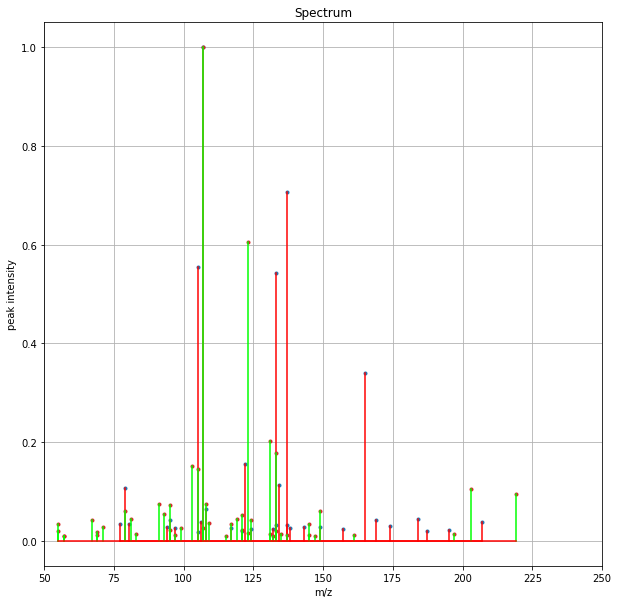

Number of peaks:  [32, 46]


In [50]:
# This is one of the above "confirmed" matches (nearly same precursor mass + cosine score > 0.5)
# Spectra still look very different!!

idx_ref = find_precursor_matches_1[0][0]
idx = find_precursor_matches_1[0][2][2]
plot_spectra([spectra_ref[idx_ref], spectra[idx]], min_mz = 50, max_mz = 250)

In [53]:
doc_ref = MS_documents_ref[idx_ref]
doc = MS_documents[idx]

In [3]:
def spec_similarity(MS_measure, 
                    doc1, doc2, 
                    doc1_weights, doc2_weights, 
                    weighing_factor = 0.5,
                    method = 'ignore'):
    """ Compare two document using a trained w2v model
    """
    # Check if everything is there:
    # 1) Check if model and bow-corpus are present
    if MS_measure.model_word2vec is None:
        print("Word2vec model first needs to be load or made (self.build_model_word2vec).")
    if len(MS_measure.bow_corpus) == 0:
        print("BOW corpus has not been calculated yet (bow_corpus).")

    # 2) Check if all words are included in trained word2vec model
    test_vocab = []
    if method == 'ignore':
        dictionary = [MS_measure.dictionary[x] for x in MS_measure.dictionary]
        for i, word in enumerate(dictionary):                
            if word not in MS_measure.model_word2vec.wv.vocab:
                test_vocab.append((i, word))
        
        if len(test_vocab) > 0:
            print("Not all 'words' of the given documents are present in the trained word2vec model!")
            _, missing_vocab = zip(*test_vocab)
    
    vector_size = MS_measure.model_word2vec.wv.vector_size
    
    term1_1 = MS_measure.model_word2vec.wv[doc1]
    term1_2 = MS_measure.model_word2vec.wv[doc2]
    doc1_weights = np.array(doc1_weights)/np.max(doc1_weights)
    doc2_weights = np.array(doc2_weights)/np.max(doc2_weights)
    
    term1_1 = term1_1 * np.tile(doc1_weights**weighing_factor, (vector_size,1)).T
    term1_2 = term1_2 * np.tile(doc2_weights**weighing_factor, (vector_size,1)).T
    spec_vec1 = np.sum(term1_1, axis=0)
    spec_vec2 = np.sum(term1_2, axis=0)
    
    return spec_vec1, spec_vec2

In [111]:
spec_vec1, spec_vec2 = spec_similarity(MS_measure, 
                    doc, doc_ref, 
                    MS_documents_intensity[idx], MS_documents_intensity_ref[idx_ref],
                    weighing_factor = 0.5,
                    method = 'ignore')

In [112]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(np.stack((spec_vec1, spec_vec2))))

[[1.         0.49283964]
 [0.49283964 1.        ]]


### Check matches of spectra based on annotated smiles!

In [7]:
# Calculate molecular fingerprints
from MS_functions import get_mol_fingerprints

molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 367
Problem with molecule 372
Problem with molecule 374
Problem with molecule 375
Problem with molecule 376
Problem with molecule 377
Problem with molecule 378
Problem with molecule 379
Problem with molecule 380
Problem with molecule 381
Problem with molecule 382
Problem with molecule 384
Problem with molecule 387
Problem with molecule 391
Problem with molecule 402
Problem with molecule 403
Problem with molecule 404
Problem with molecule 406
Problem with molecule 407
Problem with molecule 410
Problem with molecule 412
Problem with molecule 414
Problem with molecule 417
Problem with molecule 419
Problem with molecule 420
Problem with molecule 422
Problem with molecule 424
Problem with molecule 425
Problem with molecule 426
Problem with molecule 427
Problem with molecule 431
Problem with molecule 432
Problem with molecule 435
Problem with molecule 436
Problem with molecule 437
Problem with molecule 438
Problem with molecule 439
Problem with molecule 440
Problem with

Problem with molecule 1439
Problem with molecule 1440
Problem with molecule 1442
Problem with molecule 1444
Problem with molecule 1445
Problem with molecule 1447
Problem with molecule 1448
Problem with molecule 1449
Problem with molecule 1450
Problem with molecule 1451
Problem with molecule 1453
Problem with molecule 1454
Problem with molecule 1456
Problem with molecule 1457
Problem with molecule 1458
Problem with molecule 1459
Problem with molecule 1460
Problem with molecule 1461
Problem with molecule 1462
Problem with molecule 1463
Problem with molecule 1464
Problem with molecule 1466
Problem with molecule 1469
Problem with molecule 1470
Problem with molecule 1471
Problem with molecule 1474
Problem with molecule 1475
Problem with molecule 1476
Problem with molecule 1477
Problem with molecule 1478
Problem with molecule 1479
Problem with molecule 1480
Problem with molecule 1481
Problem with molecule 1482
Problem with molecule 1483
Problem with molecule 1484
Problem with molecule 1485
P

Problem with molecule 2923
Problem with molecule 2924
Problem with molecule 2925
Problem with molecule 2927
Problem with molecule 2928
Problem with molecule 2932
Problem with molecule 2933
Problem with molecule 2934
Problem with molecule 2935
Problem with molecule 2936
Problem with molecule 2937
Problem with molecule 2938
Problem with molecule 2962
Problem with molecule 2963
Problem with molecule 2965
Problem with molecule 2973
Problem with molecule 2975
Problem with molecule 3050
Problem with molecule 3053
Problem with molecule 3054
Problem with molecule 3066
Problem with molecule 3068
Problem with molecule 3069
Problem with molecule 3075
Problem with molecule 3076
Problem with molecule 3077
Problem with molecule 3078
Problem with molecule 3079
Problem with molecule 3082
Problem with molecule 3084
Problem with molecule 3087
Problem with molecule 3089
Problem with molecule 3090
Problem with molecule 3091
Problem with molecule 3092
Problem with molecule 3093
Problem with molecule 3094
P

Problem with molecule 4773
Problem with molecule 4774
Problem with molecule 4775
Problem with molecule 4776
Problem with molecule 4777
Problem with molecule 4778
Problem with molecule 4780
Problem with molecule 4781
Problem with molecule 4782
Problem with molecule 4783
Problem with molecule 4784
Problem with molecule 4785
Problem with molecule 4786
Problem with molecule 4787
Problem with molecule 4788
Problem with molecule 4789
Problem with molecule 4791
Problem with molecule 4792
Problem with molecule 4793
Problem with molecule 4794
Problem with molecule 4795
Problem with molecule 4796
Problem with molecule 4797
Problem with molecule 4798
Problem with molecule 4799
Problem with molecule 4800
Problem with molecule 4801
Problem with molecule 4802
Problem with molecule 4803
Problem with molecule 4804
Problem with molecule 4805
Problem with molecule 4806
Problem with molecule 4808
Problem with molecule 4809
Problem with molecule 4810
Problem with molecule 4811
Problem with molecule 4812
P

Problem with molecule 6198
Problem with molecule 6199
Problem with molecule 6200
Problem with molecule 6202
Problem with molecule 6204
Problem with molecule 6207
Problem with molecule 6208
Problem with molecule 6212
Problem with molecule 6214
Problem with molecule 6215
Problem with molecule 6216
Problem with molecule 6219
Problem with molecule 6220
Problem with molecule 6225
Problem with molecule 6227
Problem with molecule 6228
Problem with molecule 6229
Problem with molecule 6230
Problem with molecule 6235
Problem with molecule 6236
Problem with molecule 6237
Problem with molecule 6239
Problem with molecule 6241
Problem with molecule 6243
Problem with molecule 6244
Problem with molecule 6246
Problem with molecule 6249
Problem with molecule 6250
Problem with molecule 6251
Problem with molecule 6253
Problem with molecule 6255
Problem with molecule 6256
Problem with molecule 6259
Problem with molecule 6260
Problem with molecule 6261
Problem with molecule 6265
Problem with molecule 6266
P

Problem with molecule 7333
Problem with molecule 7338
Problem with molecule 7339
Problem with molecule 7342
Problem with molecule 7346
Problem with molecule 7347
Problem with molecule 7361
Problem with molecule 7362
Problem with molecule 7365
Problem with molecule 7369
Problem with molecule 7370
Problem with molecule 7377
Problem with molecule 7387
Problem with molecule 7394
Problem with molecule 7402
Problem with molecule 7405
Problem with molecule 7408
Problem with molecule 7409
Problem with molecule 7411
Problem with molecule 7414
Problem with molecule 7418
Problem with molecule 7419
Problem with molecule 7420
Problem with molecule 7421
Problem with molecule 7424
Problem with molecule 7428
Problem with molecule 7429
Problem with molecule 7440
Problem with molecule 7448
Problem with molecule 7451
Problem with molecule 7452
Problem with molecule 7453
Problem with molecule 7457
Problem with molecule 7469
Problem with molecule 7470
Problem with molecule 7476
Problem with molecule 7493
P

Problem with molecule 9225
Problem with molecule 9226
Problem with molecule 9227
Problem with molecule 9228
Problem with molecule 9229
Problem with molecule 9230
Problem with molecule 9231
Problem with molecule 9232
Problem with molecule 9233
Problem with molecule 9234
Problem with molecule 9235
Problem with molecule 9236
Problem with molecule 9237
Problem with molecule 9238
Problem with molecule 9239
Problem with molecule 9240
Problem with molecule 9241
Problem with molecule 9242
Problem with molecule 9247
Problem with molecule 9248
Problem with molecule 9249
Problem with molecule 9250
Problem with molecule 9251
Problem with molecule 9252
Problem with molecule 9253
Problem with molecule 9254
Problem with molecule 9255
Problem with molecule 9256
Problem with molecule 9257
Problem with molecule 9258
Problem with molecule 9259
Problem with molecule 9260
Problem with molecule 9261
Problem with molecule 9262
Problem with molecule 9263
Problem with molecule 9264
Problem with molecule 9265
P

Problem with molecule 10460
Problem with molecule 10461
Problem with molecule 10462
Problem with molecule 10467
Problem with molecule 10468
Problem with molecule 10469
Problem with molecule 10470
Problem with molecule 10472
Problem with molecule 10473
Problem with molecule 10474
Problem with molecule 10475
Problem with molecule 10476
Problem with molecule 10477
Problem with molecule 10478
Problem with molecule 10479
Problem with molecule 10480
Problem with molecule 10481
Problem with molecule 10482
Problem with molecule 10483
Problem with molecule 10484
Problem with molecule 10485
Problem with molecule 10486
Problem with molecule 10487
Problem with molecule 10488
Problem with molecule 10489
Problem with molecule 10490
Problem with molecule 10491
Problem with molecule 10492
Problem with molecule 10493
Problem with molecule 10494
Problem with molecule 10495
Problem with molecule 10496
Problem with molecule 10497
Problem with molecule 10498
Problem with molecule 10499
Problem with molecul

Problem with molecule 11904
Problem with molecule 11905
Problem with molecule 11906
Problem with molecule 11907
Problem with molecule 11908
Problem with molecule 11909
Problem with molecule 11910
Problem with molecule 11911
Problem with molecule 11912
Problem with molecule 11913
Problem with molecule 11914
Problem with molecule 11915
Problem with molecule 11916
Problem with molecule 11917
Problem with molecule 11918
Problem with molecule 11919
Problem with molecule 11920
Problem with molecule 11921
Problem with molecule 11922
Problem with molecule 11923
Problem with molecule 11924
Problem with molecule 11925
Problem with molecule 11926
Problem with molecule 11927
Problem with molecule 11928
Problem with molecule 11929
Problem with molecule 11930
Problem with molecule 11932
Problem with molecule 11933
Problem with molecule 11934
Problem with molecule 11935
Problem with molecule 11936
Problem with molecule 11937
Problem with molecule 11938
Problem with molecule 11939
Problem with molecul

Problem with molecule 15580
Problem with molecule 15583
Problem with molecule 15590
Problem with molecule 15591
Problem with molecule 15593
Problem with molecule 16039
Problem with molecule 16042
Problem with molecule 16051
Problem with molecule 16053
Problem with molecule 16773
Problem with molecule 16774
Problem with molecule 16775
Problem with molecule 16776
Problem with molecule 16777
Problem with molecule 16778
Problem with molecule 16779
Problem with molecule 16780
Problem with molecule 16781
Problem with molecule 16782
Problem with molecule 16786
Problem with molecule 16787
Problem with molecule 16788
Problem with molecule 16789
Problem with molecule 16790
Problem with molecule 16791
Problem with molecule 16792
Problem with molecule 16793
Problem with molecule 16794
Problem with molecule 16795
Problem with molecule 16796
Problem with molecule 16797
Problem with molecule 16798
Problem with molecule 16799
Problem with molecule 16800
Problem with molecule 16801
Problem with molecul

Problem with molecule 18134
Problem with molecule 18135
Problem with molecule 18136
Problem with molecule 18137
Problem with molecule 18138
Problem with molecule 18139
Problem with molecule 18140
Problem with molecule 18141
Problem with molecule 18142
Problem with molecule 18143
Problem with molecule 18144
Problem with molecule 18145
Problem with molecule 18146
Problem with molecule 18147
Problem with molecule 18148
Problem with molecule 18149
Problem with molecule 18150
Problem with molecule 18151
Problem with molecule 18152
Problem with molecule 18153
Problem with molecule 18154
Problem with molecule 18155
Problem with molecule 18156
Problem with molecule 18157
Problem with molecule 18158
Problem with molecule 18159
Problem with molecule 18160
Problem with molecule 18161
Problem with molecule 18162
Problem with molecule 18163
Problem with molecule 18164
Problem with molecule 18165
Problem with molecule 18166
Problem with molecule 18167
Problem with molecule 18168
Problem with molecul

Problem with molecule 19287
Problem with molecule 19288
Problem with molecule 19289
Problem with molecule 19290
Problem with molecule 19291
Problem with molecule 19292
Problem with molecule 19293
Problem with molecule 19294
Problem with molecule 19295
Problem with molecule 19296
Problem with molecule 19297
Problem with molecule 19298
Problem with molecule 19299
Problem with molecule 19300
Problem with molecule 19301
Problem with molecule 19302
Problem with molecule 19303
Problem with molecule 19304
Problem with molecule 19305
Problem with molecule 19306
Problem with molecule 19312
Problem with molecule 19313
Problem with molecule 19314
Problem with molecule 19315
Problem with molecule 19316
Problem with molecule 19317
Problem with molecule 19318
Problem with molecule 19319
Problem with molecule 19320
Problem with molecule 19321
Problem with molecule 19322
Problem with molecule 19323
Problem with molecule 19324
Problem with molecule 19325
Problem with molecule 19326
Problem with molecul

Problem with molecule 20410
Problem with molecule 20411
Problem with molecule 20412
Problem with molecule 20413
Problem with molecule 20414
Problem with molecule 20415
Problem with molecule 20416
Problem with molecule 20417
Problem with molecule 20418
Problem with molecule 20419
Problem with molecule 20420
Problem with molecule 20421
Problem with molecule 20422
Problem with molecule 20423
Problem with molecule 20424
Problem with molecule 20425
Problem with molecule 20426
Problem with molecule 20427
Problem with molecule 20428
Problem with molecule 20429
Problem with molecule 20430
Problem with molecule 20431
Problem with molecule 20432
Problem with molecule 20433
Problem with molecule 20434
Problem with molecule 20435
Problem with molecule 20436
Problem with molecule 20437
Problem with molecule 20439
Problem with molecule 20443
Problem with molecule 20444
Problem with molecule 20445
Problem with molecule 20446
Problem with molecule 20447
Problem with molecule 20448
Problem with molecul

Problem with molecule 25844
Problem with molecule 25845
Problem with molecule 25846
Problem with molecule 25847
Problem with molecule 25848
Problem with molecule 25849
Problem with molecule 25850
Problem with molecule 25851
Problem with molecule 25852
Problem with molecule 25853
Problem with molecule 25854
Problem with molecule 25855
Problem with molecule 25856
Problem with molecule 25857
Problem with molecule 25858
Problem with molecule 25859
Problem with molecule 25860
Problem with molecule 25861
Problem with molecule 25862
Problem with molecule 25863
Problem with molecule 25870
Problem with molecule 25871
Problem with molecule 25872
Problem with molecule 25873
Problem with molecule 25874
Problem with molecule 25875
Problem with molecule 25876
Problem with molecule 25877
Problem with molecule 25878
Problem with molecule 25879
Problem with molecule 25880
Problem with molecule 25881
Problem with molecule 25882
Problem with molecule 25883
Problem with molecule 25884
Problem with molecul

Problem with molecule 26958
Problem with molecule 26959
Problem with molecule 26960
Problem with molecule 26961
Problem with molecule 26962
Problem with molecule 26963
Problem with molecule 26964
Problem with molecule 26965
Problem with molecule 26966
Problem with molecule 26967
Problem with molecule 26968
Problem with molecule 26969
Problem with molecule 26970
Problem with molecule 26971
Problem with molecule 26972
Problem with molecule 26973
Problem with molecule 26974
Problem with molecule 26975
Problem with molecule 26976
Problem with molecule 26977
Problem with molecule 26978
Problem with molecule 26979
Problem with molecule 26980
Problem with molecule 26981
Problem with molecule 26982
Problem with molecule 26983
Problem with molecule 26984
Problem with molecule 26985
Problem with molecule 26986
Problem with molecule 26987
Problem with molecule 26988
Problem with molecule 26989
Problem with molecule 26990
Problem with molecule 26991
Problem with molecule 26992
Problem with molecul

Problem with molecule 27975
Problem with molecule 27976
Problem with molecule 27977
Problem with molecule 27978
Problem with molecule 27979
Problem with molecule 27980
Problem with molecule 27981
Problem with molecule 27982
Problem with molecule 27983
Problem with molecule 27984
Problem with molecule 27985
Problem with molecule 27986
Problem with molecule 27987
Problem with molecule 27988
Problem with molecule 27989
Problem with molecule 27990
Problem with molecule 27991
Problem with molecule 27992
Problem with molecule 27993
Problem with molecule 27994
Problem with molecule 27995
Problem with molecule 27996
Problem with molecule 27997
Problem with molecule 27998
Problem with molecule 27999
Problem with molecule 28011
Problem with molecule 28012
Problem with molecule 28013
Problem with molecule 28014
Problem with molecule 28015
Problem with molecule 28016
Problem with molecule 28017
Problem with molecule 28018
Problem with molecule 28019
Problem with molecule 28020
Problem with molecul

Problem with molecule 29059
Problem with molecule 29060
Problem with molecule 29061
Problem with molecule 29062
Problem with molecule 29063
Problem with molecule 29064
Problem with molecule 29065
Problem with molecule 29066
Problem with molecule 29067
Problem with molecule 29068
Problem with molecule 29069
Problem with molecule 29070
Problem with molecule 29071
Problem with molecule 29072
Problem with molecule 29073
Problem with molecule 29074
Problem with molecule 29075
Problem with molecule 29076
Problem with molecule 29077
Problem with molecule 29078
Problem with molecule 29079
Problem with molecule 29080
Problem with molecule 29081
Problem with molecule 29082
Problem with molecule 29083
Problem with molecule 29084
Problem with molecule 29085
Problem with molecule 29086
Problem with molecule 29087
Problem with molecule 29088
Problem with molecule 29089
Problem with molecule 29090
Problem with molecule 29091
Problem with molecule 29092
Problem with molecule 29093
Problem with molecul

Problem with molecule 30321
Problem with molecule 30322
Problem with molecule 30323
Problem with molecule 30324
Problem with molecule 30325
Problem with molecule 30326
Problem with molecule 30327
Problem with molecule 30328
Problem with molecule 30329
Problem with molecule 30330
Problem with molecule 30331
Problem with molecule 30332
Problem with molecule 30333
Problem with molecule 30334
Problem with molecule 30335
Problem with molecule 30336
Problem with molecule 30337
Problem with molecule 30338
Problem with molecule 30339
Problem with molecule 30340
Problem with molecule 30341
Problem with molecule 30342
Problem with molecule 30343
Problem with molecule 30344
Problem with molecule 30345
Problem with molecule 30346
Problem with molecule 30347
Problem with molecule 30348
Problem with molecule 30349
Problem with molecule 30350
Problem with molecule 30351
Problem with molecule 30352
Problem with molecule 30353
Problem with molecule 30354
Problem with molecule 30355
Problem with molecul

Problem with molecule 50791
Problem with molecule 50795
Problem with molecule 50808
Problem with molecule 50809
Problem with molecule 50815
Problem with molecule 50818
Problem with molecule 52391
Problem with molecule 52392
Problem with molecule 52393
Problem with molecule 52395
Problem with molecule 52396
Problem with molecule 52397
Problem with molecule 52398
Problem with molecule 52399
Problem with molecule 52400
Problem with molecule 52402
Problem with molecule 52403
Problem with molecule 52404
Problem with molecule 52405
Problem with molecule 52406
Problem with molecule 52407
Problem with molecule 52409
Problem with molecule 52410
Problem with molecule 52411
Problem with molecule 52412
Problem with molecule 52413
Problem with molecule 52414
Problem with molecule 52416
Problem with molecule 52418
Problem with molecule 52419
Problem with molecule 52420
Problem with molecule 52422
Problem with molecule 52423
Problem with molecule 52432
Problem with molecule 52433
Problem with molecul

Problem with molecule 52965
Problem with molecule 52966
Problem with molecule 52967
Problem with molecule 52968
Problem with molecule 52969
Problem with molecule 52971
Problem with molecule 52972
Problem with molecule 52973
Problem with molecule 52974
Problem with molecule 52975
Problem with molecule 52976
Problem with molecule 52978
Problem with molecule 52979
Problem with molecule 52980
Problem with molecule 52981
Problem with molecule 52982
Problem with molecule 52983
Problem with molecule 52984
Problem with molecule 52986
Problem with molecule 52987
Problem with molecule 52988
Problem with molecule 52989
Problem with molecule 52990
Problem with molecule 52991
Problem with molecule 52993
Problem with molecule 52994
Problem with molecule 52995
Problem with molecule 52996
Problem with molecule 52997
Problem with molecule 52998
Problem with molecule 53000
Problem with molecule 53001
Problem with molecule 53002
Problem with molecule 53003
Problem with molecule 53004
Problem with molecul

Problem with molecule 55291
Problem with molecule 55292
Problem with molecule 55293
Problem with molecule 55294
Problem with molecule 55295
Problem with molecule 55296
Problem with molecule 55297
Problem with molecule 55298
Problem with molecule 55299
Problem with molecule 55300
Problem with molecule 55301
Problem with molecule 55302
Problem with molecule 55303
Problem with molecule 55304
Problem with molecule 55305
Problem with molecule 55306
Problem with molecule 55307
Problem with molecule 55308
Problem with molecule 55309
Problem with molecule 55310
Problem with molecule 55311
Problem with molecule 55312
Problem with molecule 55313
Problem with molecule 55314
Problem with molecule 55315
Problem with molecule 55316
Problem with molecule 55317
Problem with molecule 55318
Problem with molecule 55319
Problem with molecule 55320
Problem with molecule 55321
Problem with molecule 55322
Problem with molecule 55323
Problem with molecule 55324
Problem with molecule 55325
Problem with molecul

In [9]:
len(exclude)

17849

--> means that 17849 out of the 55,000 spectra have only inchikeys, not inchi or smiles.  
Maybe stick to inchikeys than... ?

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols

inchikeys = []
for spec in spectra:
    if "inchikey" in spec.metadata:
        inchikeys.append(spec.metadata["inchikey"])
    elif "inchi" in spec.metadata:
        inchikeys.append(Chem.inchi.InchiToInchiKey(spec.metadata["inchi"]))
    elif "smiles" in spec.metadata:
        inchikeys.append(Chem.MolToInchiKey(Chem.Chem.MolFromSmiles(spec.metadata["smiles"])))
    else:
        inchikeys.append(0)

In [16]:
inchikeys.count(0)

0

In [14]:
inchikeys[0]

'KBDOXLBZVFQTMH-RXRQAHPVSA-N'

In [23]:
print("Number of unique inchikeys: ", len(list(set(inchikeys))))

Number of unique inchikeys:  2470


In [24]:
inchikeys_ref = []
for spec in spectra_ref:
    if "inchikey" in spec.metadata:
        inchikeys_ref.append(spec.metadata["inchikey"])
    elif "inchi" in spec.metadata:
        inchikeys_ref.append(Chem.inchi.InchiToInchiKey(spec.metadata["inchi"]))
    elif "smiles" in spec.metadata:
        inchikeys_ref.append(Chem.MolToInchiKey(Chem.Chem.MolFromSmiles(spec.metadata["smiles"])))
    else:
        inchikeys_ref.append(0)

In [27]:
inchikey_matches = [x for x in inchikeys_ref if x in inchikeys]

In [28]:
len(inchikey_matches)

1355

In [31]:
# compare allGNPS and uniquesmiles MGFs
find_precursor_matches = []
find_precursor_matches_confirmed = []
find_precursor_matches_not_confirmed = []
find_precursor_matches_1 = []
find_target_matched = np.zeros((len(spectra_ref)))

# set minimal precision
decimals = 1

target_mz = np.array(sub_spectra_metadata['precursor_mz'])
target_mz  = np.round(target_mz, decimals)

for i, precursor_mz in enumerate(sub_spectra_metadata_ref['precursor_mz']):
    found_ones = np.where(target_mz == np.round(precursor_mz, decimals))[0]
    if len(found_ones) > 0:
        find_precursor_matches.append(1)
        cosine_scores = []
        #for one in found_ones:
        #    cosine_scores.append(MS_functions.cosine_score(spectra_ref[i], spectra[one], tol = 0.5)[0])
        #find_precursor_matches_1.append((i, precursor_mz, found_ones, cosine_scores))   
        if inchikeys_ref[i] in inchikeys:
            find_precursor_matches_confirmed.append((i, inchikeys_ref[i]))
        else:
            find_precursor_matches_not_confirmed.append((i, inchikeys_ref[i]))
    else:
        find_precursor_matches.append(0)

print("Found", np.sum(np.array(find_precursor_matches)), " matches.")
#found_IDX = np.where(np.array(find_precursor_matches) == 1)

print("Found", len(find_precursor_matches_confirmed), " confirmed matches.")

Found 8183  matches.
Found 1313  confirmed matches.


### Note:
With a precision of 4 deciamls, matching precursor m/z are only found for 2474 out of 9550 spectra from unique_smiles dataset. And only 911 of those have a cosine score higher than 0.5!

#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [8]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents_ref)

Using TensorFlow backend.


In [9]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  68392


***
## 2. Plotting functions

In [4]:
import matplotlib
from matplotlib import pyplot as plt

def binned_scatter_plot(bins_x, 
                        bins_y, 
                        H, 
                        edges, 
                        label):
    data_x = []
    data_y = []
    data_z = []
    data_y_mean = []
    for i in range(bins_x):
        for j in range(bins_y):
            data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
            data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
            mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
            data_y_mean.append(mean_mol_score)
            data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))
            
    fig, ax = plt.subplots(figsize=(15,10))
    cm = plt.cm.get_cmap('viridis')
    #100*np.array(data_z)**0.5 c=data_y, 
    ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
    plt.plot(data_x, data_y_mean, color='black')
    plt.xlabel("g(s,s') (" + label + ")")
    plt.ylabel("molecular similarity (f(t,t'))")

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

In [5]:
def plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 1.0):
    
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))
    ref_score_cum = np.array(ref_score_cum)
                         
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
    #plt.xlim(show_top_percentile, 0)
    
    return ref_score_cum

***
## 3. For benchmarking: molecular similarity
Benchmarking - Reference score is molecular similarity (based on mol. fingerprints)

### Calculate/load molecular similarity scores
+ first calculate molecular fingerprints
+ then calculate (or load if file exists) molecular similarity scores.  

Method for calculating fingerprints here can be "morgan1", "morgan2", "morgan3" or "daylight". For morgan fingerprints scores will be based on Dice scores. For "daylight" fingerprint it will be Tanimoto scores. 

In [11]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

### Get molecular similarity matrix (based on molecular fingerprints).  

In [19]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
M_sim_morgan3 = MS_functions.mol_sim_matrix_symmetric(spectra, 
                                              [],#fingerprints_m3,
                                              filename = filename)

Molecular similarity scores found and loaded.


***
# 4. Model trained on dataset itself (unique smiles)
This is (probably) the best performing setting.

## 4.1. Spec2Vec: re-done, exp filter 0.01,

In [148]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_uniquesmiles_d300_w500_iter100_loss500_minpeak10_dec2_exp001.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [149]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.  documents. 4400  of  9550  documents.6060  of  9550  documents. Calculated centroid vectors for  6240  of  9550  documents. 8150  of  9550  documents. Calculated centroid vectors for  8810  of  9550  documents.

### Calculate all-vs-all similarity matrix

In [150]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [28]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

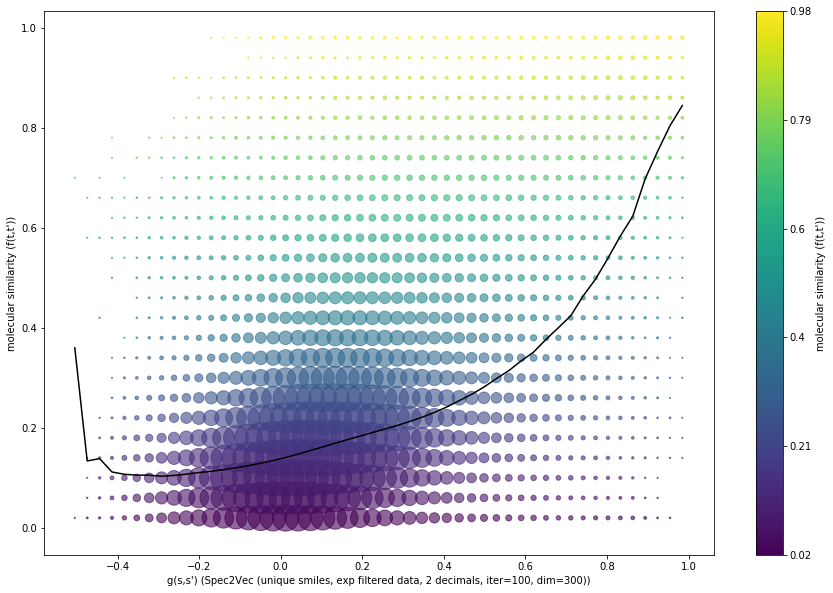

In [29]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (unique smiles, exp filtered data, 2 decimals, iter=100, dim=300)")

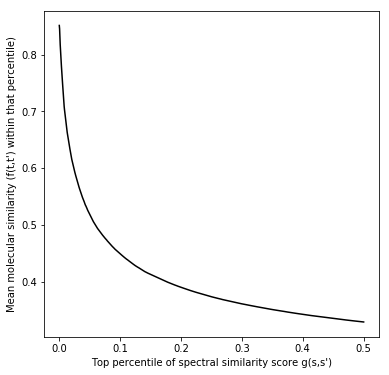

In [30]:
ref_score_w2v_cum_dec2_exp001_iter100_d300 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_uniquesmiles_dec2_exp001_iter100_d300.npy', ref_score_w2v_uniquesmiles_dec2_exp001_iter100_d300)

## 4.2. Spec2Vec: exp filter 0.01, no Tfidf!

In [79]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_uniquesmiles_d300_w500_iter100_loss500_minpeak10_dec2_exp001.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [82]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity_ref, 
                             tfidf_weighted = False, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  9550  of  9550  documents. documents.4340  of  9550  documents. documents.9550  documents.  documents.

### Calculate all-vs-all similarity matrix

In [83]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [84]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

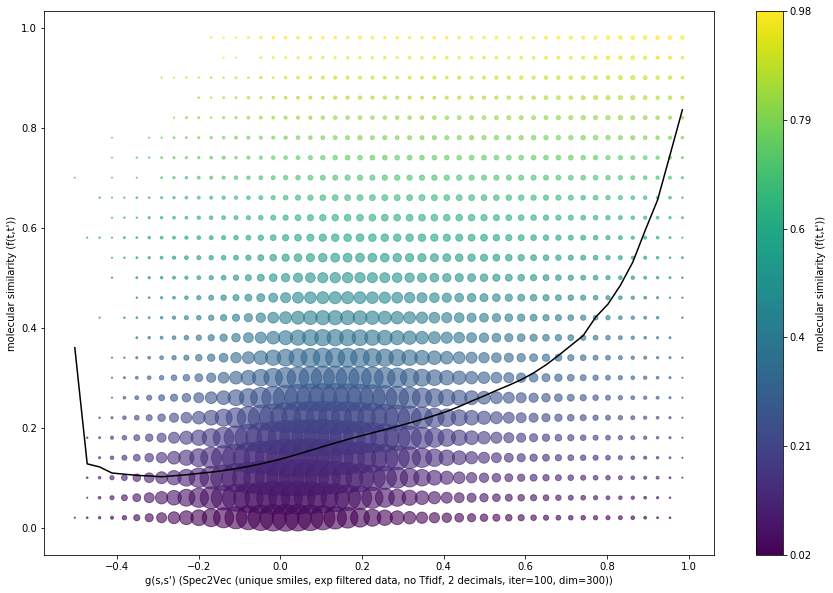

In [85]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (unique smiles, exp filtered data, no Tfidf, 2 decimals, iter=100, dim=300)")

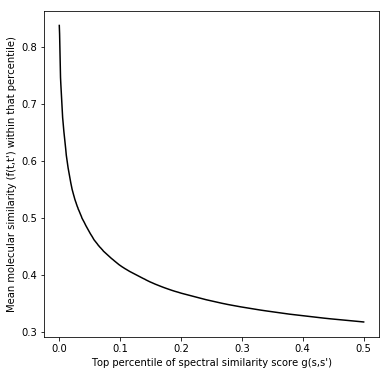

In [86]:
ref_score_uniquesmiles_noTfidf_dec2_exp001_iter100_d300 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_uniquesmiles_noTfidf_dec2_exp001_iter100_d300.npy', ref_score_uniquesmiles_noTfidf_dec2_exp001_iter100_d300)

***
# 5. Model trained on all gnps library selection 


## 5.0. Spec2Vec: exp filter 0.01,

In [36]:
#with old parser: file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_LibrariesAllSmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_LibrariesAllSmiles_d300_w500_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [37]:
len(MS_measure.model_word2vec.wv.vocab)

137967

In [38]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity_ref, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
450  out of  68392  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.9550  documents. of  9550  documents. 9550  documents. 9550  documents. 9550  documents.9550  documents. 9550  documents.  documents.9550  documents.  documents. 8770  of  9550  documents.

### Calculate all-vs-all similarity matrix

In [39]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [16]:
remove_diagonal = []
length = 9550#M_sim_ctr.shape[0]
for i in range(length):
    remove_diagonal.append(i*length + i)

remove_diagonal = np.array(remove_diagonal)

In [40]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

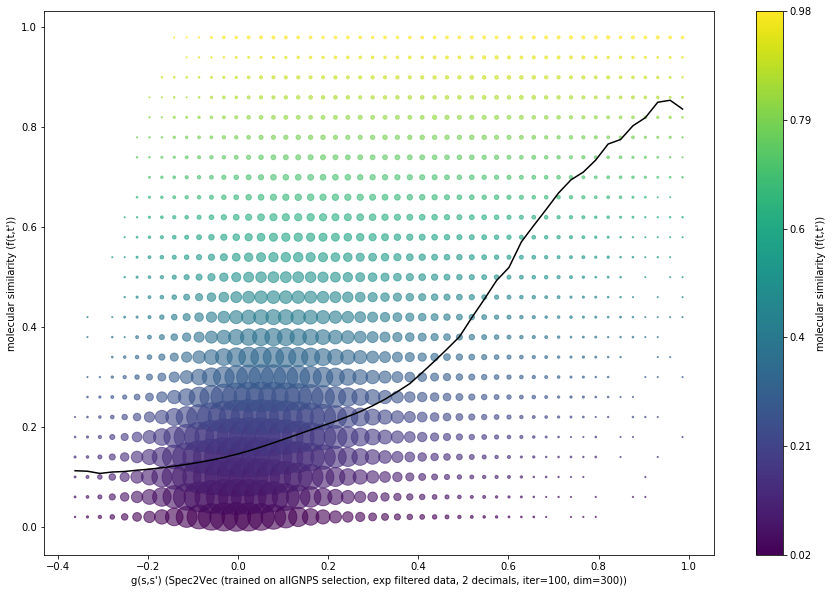

In [41]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on allGNPS selection, exp filtered data, 2 decimals, iter=100, dim=300)")

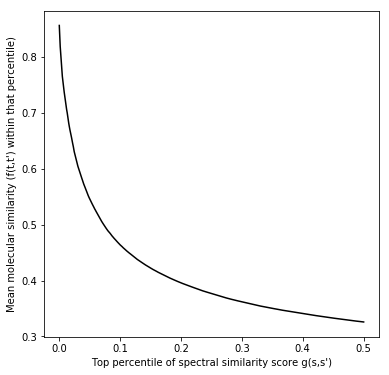

In [43]:
ref_score_w2v_allGNPS_minpeaks10_dec2_exp001_iter100_d300 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_allGNPS_minpeaks10_dec2_exp001_iter100_d300.npy', ref_score_w2v_allGNPS_minpeaks10_dec2_exp001_iter100_d300)

# 5.1. Spec2Vec: exp filter 0.01, no-tfidf!

In [44]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_LibrariesAllSmiles_d300_w500_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [45]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity_ref, 
                             tfidf_weighted = False, #True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
450  out of  68392  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
  Calculated centroid vectors for  9550  of  9550  documents. documents. of  9550  documents. 9550  documents.9550  documents.9550  documents.  documents.9550  documents.9160  of  9550  documents.9550  documents.

### Calculate all-vs-all similarity matrix

In [46]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [47]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

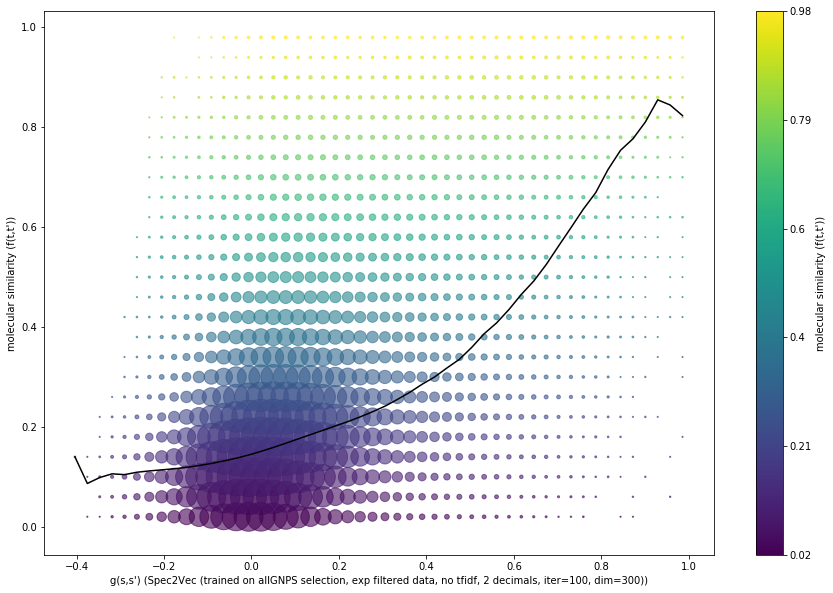

In [48]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on allGNPS selection, exp filtered data, no tfidf, 2 decimals, iter=100, dim=300)")

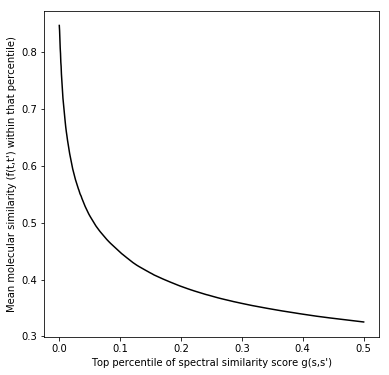

In [49]:
ref_score_w2v_allGNPS_minpeaks10_noTfidf_dec2_exp001_iter100_d300 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_allGNPS_minpeaks10_noTfidf_dec2_exp001_iter100_d300.npy', ref_score_w2v_allGNPS_minpeaks10_noTfidf_dec2_exp001_iter100_d300)

***
# 6. Model trained on all gnps library selection (min_peaks = 1)


## 6.0. Spec2Vec: exp filter 0.01, 

In [55]:
# old file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_LibrariesAllSmiles_d300_w300_iter100_loss500_dec2.model'
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_LibrariesAllSmiles_d300_w500_iter100_loss500_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [56]:
len(MS_measure.model_word2vec.wv.vocab)

137000

In [57]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity_ref, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
596  out of  68392  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents. documents.9550  documents. of  9550  documents. 2200  of  9550  documents. of  9550  documents.9550  documents.

In [58]:
len(MS_measure.model_word2vec.wv.vocab)

137596

### Calculate all-vs-all similarity matrix

In [59]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [60]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

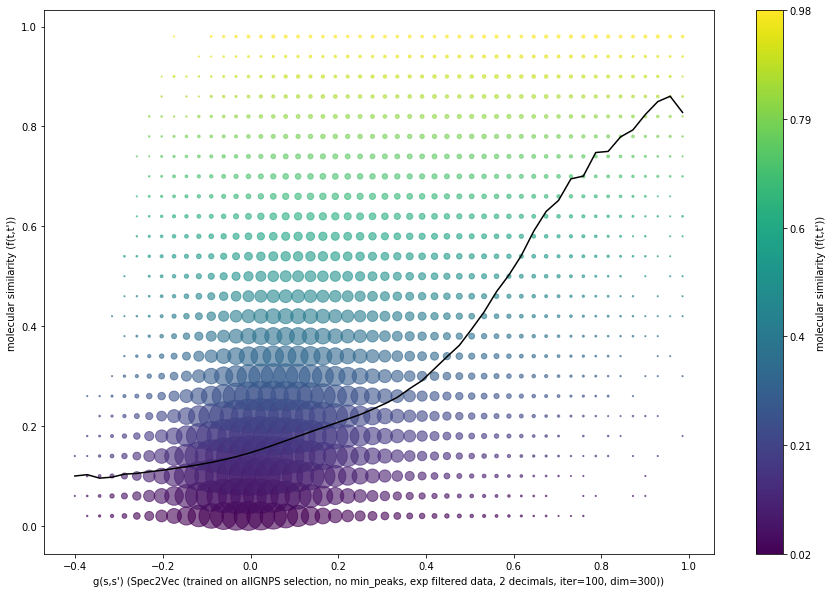

In [61]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on allGNPS selection, no min_peaks, exp filtered data, 2 decimals, iter=100, dim=300)")

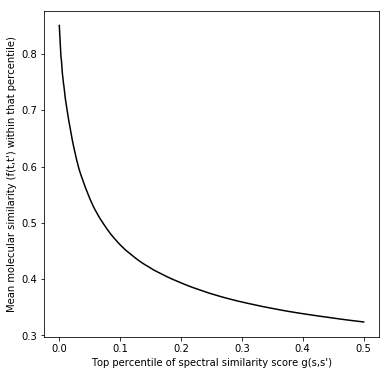

In [62]:
ref_score_allGNPS_minpeaks1_dec2_exp001_iter100_d300 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_allGNPS_minpeaks1_dec2_exp001_iter100_d300.npy', ref_score_allGNPS_minpeaks1_dec2_exp001_iter100_d300)

## 6.1. Spec2Vec: exp filter 0.01, no Tfidf!

In [64]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_LibrariesAllSmiles_d300_w500_iter100_loss500_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [65]:
len(MS_measure.model_word2vec.wv.vocab)

137000

In [66]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity_ref, 
                             tfidf_weighted = False, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
596  out of  68392  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
  Calculated centroid vectors for  9550  of  9550  documents. Calculated centroid vectors for  3860  of  9550  documents. of  9550  documents. 9550  documents.  documents.  documents. of  9550  documents.

In [14]:
len(MS_measure.model_word2vec.wv.vocab)

137596

### Calculate all-vs-all similarity matrix

In [67]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [68]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

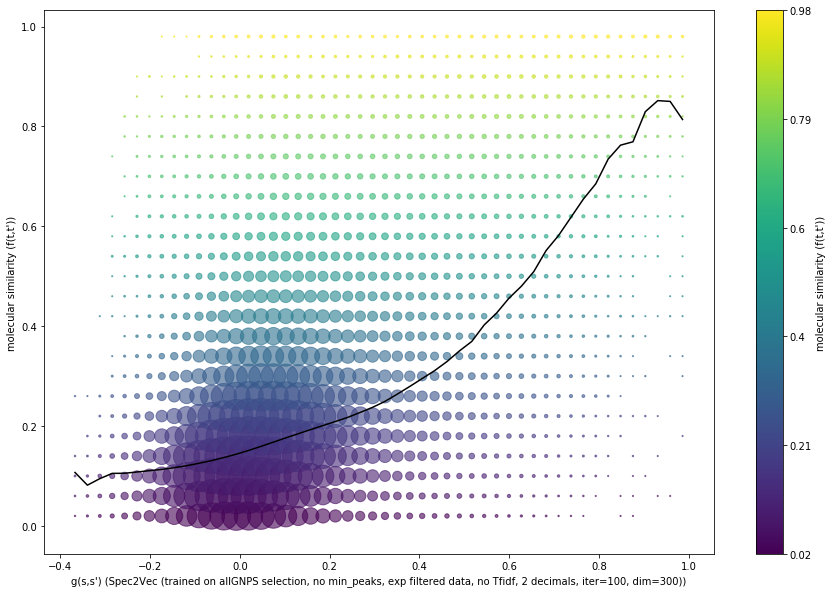

In [69]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on allGNPS selection, no min_peaks, exp filtered data, no Tfidf, 2 decimals, iter=100, dim=300)")

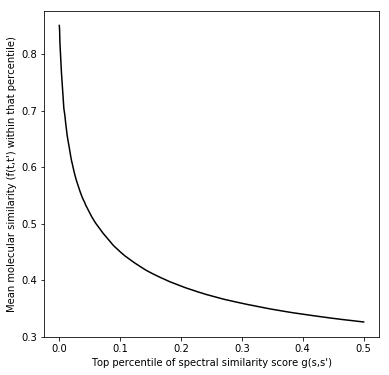

In [70]:
ref_score_allGNPS_minpeaks1_noTfidf_dec2_exp001_iter100_d300 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_allGNPS_minpeaks1_noTfidf_dec2_exp001_iter100_d300.npy', ref_score_allGNPS_minpeaks1_noTfidf_dec2_exp001_iter100_d300)

## Comparisons

In [27]:
# load previously calculated curves
ref_score_w2v_uniquesmiles_dec2_exp001_iter100_d300 = np.load('spec2vec_uniquesmiles_dec2_exp001_iter100_d300.npy')
ref_score_w2v_allGNPS_dec2_exp001_iter100_d300 = np.load('spec2vec_allGNPS_dec2_exp001_iter100_d300.npy')

In [24]:
ref_score_cosine_cum002 = np.load('cosine_percentile_tol002_minmatch6.npy')
ref_score_cosine_cum0005 = np.load('cosine_percentile_tol0005_minmatch6.npy')

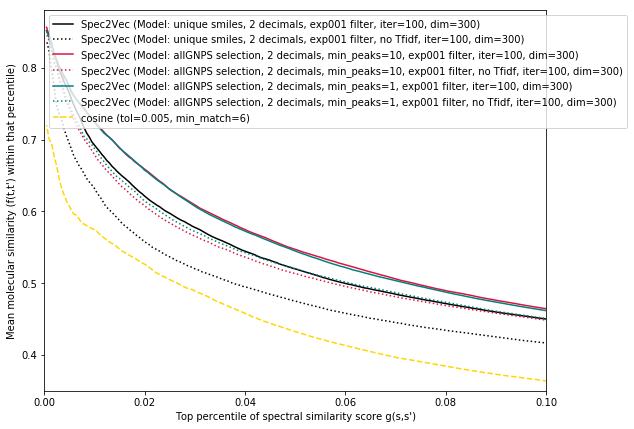

In [87]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

#cmap2 = matplotlib.cm.get_cmap('winter')

fig, ax = plt.subplots(figsize=(9,7))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_exp001_iter100_d300, 
         color='black',
         label='Spec2Vec (Model: unique smiles, 2 decimals, exp001 filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_uniquesmiles_noTfidf_dec2_exp001_iter100_d300, 
         ':', color='black',
         label='Spec2Vec (Model: unique smiles, 2 decimals, exp001 filter, no Tfidf, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_allGNPS_minpeaks10_dec2_exp001_iter100_d300, 
         color='crimson', #'darkblue',
         label='Spec2Vec (Model: allGNPS selection, 2 decimals, min_peaks=10, exp001 filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_allGNPS_minpeaks10_noTfidf_dec2_exp001_iter100_d300, 
         ':', color='crimson', #'purple', #'darkblue',
         label='Spec2Vec (Model: allGNPS selection, 2 decimals, min_peaks=10, exp001 filter, no Tfidf, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_allGNPS_minpeaks1_dec2_exp001_iter100_d300, 
         color='teal',
         label='Spec2Vec (Model: allGNPS selection, 2 decimals, min_peaks=1, exp001 filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_allGNPS_minpeaks1_noTfidf_dec2_exp001_iter100_d300, 
         ':', color='teal', #'darkblue', 
         label='Spec2Vec (Model: allGNPS selection, 2 decimals, min_peaks=1, exp001 filter, no Tfidf, iter=100, dim=300)')

ref_score_allGNPS_minpeaks1_noTfidf_dec2_exp001_iter100_d300
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum0005, 
         '--', color='gold', #cmap1(1.0), #'pink',
         label='cosine (tol=0.005, min_match=6)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.35, 0.88)
plt.savefig('Top_percentile_allGNPS_selection.pdf')

## Notes/ ToDos:
+ test filter with modified min_peaks functioN!

## Further explore some of the best results (here: min_peaks=10, allGNPS)

In [89]:
PATH_CLASSYFIRE = ROOT + "\\Data\\labeled_MS_data\\"
csvfile = PATH_CLASSYFIRE + "ClassyFire_InputforCytoscape_GNPSLibraries.csv"     

import pandas as pd
mol_classes = pd.read_csv(csvfile, delimiter='\t')  

In [91]:
list_mol_superclasses = []
list_mol_classes = []
list_mol_subclasses = []

for spectrum in spectra_ref:
    subtable = mol_classes[mol_classes['inchikey'].str.contains(spectrum.metadata['inchikey'])]
    
    if subtable.shape[0] > 0:  # i.e. if match was found
        list_mol_superclasses.append(subtable['superclass'].values[0])
        list_mol_classes.append(subtable['class'].values[0])
        list_mol_subclasses.append(subtable['subclass'].values[0])
    else:
        list_mol_superclasses.append('None')
        list_mol_classes.append('None')
        list_mol_subclasses.append('None')
    
# Remove nan's
list_mol_superclasses = ['None' if x is np.nan else x for x in list_mol_superclasses]
list_mol_classes = ['None' if x is np.nan else x for x in list_mol_classes]
list_mol_subclasses = ['None' if x is np.nan else x for x in list_mol_subclasses]

In [92]:
#with old parser: file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_LibrariesAllSmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_LibrariesAllSmiles_d300_w500_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [93]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity_ref, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
450  out of  68392  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.of  9550  documents.9550  documents. Calculated centroid vectors for  1510  of  9550  documents.9550  documents.1750  of  9550  documents. Calculated centroid vectors for  2090  of  9550  documents. Calculated centroid vectors for  2140  of  9550  documents.9550  documents. Calculated centroid vectors for  3480  of  9550  documents. 9550  documents.  documents. Calculated centroid vectors for  6010  of  9550  documents.  documents. of  9550  documents. 9550  documents. Calculated centroid vectors for  8750  of  9550  documents. 9120  of  9550  documents. of  9550  documents.

In [95]:
MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

Calculated distances between  9550  documents.


In [96]:
#MS_measure.get_centroid_distances(num_hits=25, method='cosine')

# Compare word2vec/similarity score
list_similars_ctr_idx = MS_measure.list_similars_ctr_idx
list_similars_ctr = MS_measure.list_similars_ctr

In [ ]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol05_minmatch6_fast.npy"
M_sim_molnet = np.load(filename)



In [ ]:
num_candidates = 25
cosine_similars_idx = np.zeros((len(spectra), num_candidates))
molnet_similars_idx = np.zeros((len(spectra), num_candidates))
morgan3_similars_idx = np.zeros((len(spectra), num_candidates))
random_similars_idx = np.zeros((len(spectra), num_candidates))

IDs = np.arange(len(spectra))

for i in range(len(spectra)):        
    # Compare to cosine score
    cosine_candidates = M_sim_cosine2[i,:].argsort()[-num_candidates:][::-1]
    
    # Compare to molecular networking score
    molnet_candidates = M_sim_molnet[i,:].argsort()[-num_candidates:][::-1]

    # Compare to maximum possible Tanimoto score
    morgan3_candidates = M_sim_morgan3[i,:].argsort()[-num_candidates:][::-1] 
    
    # Compare to random choice score
    IDs_new = np.delete(IDs, i)
    random_candidates = np.random.choice(IDs, size = num_candidates-1, replace=False)
    
    cosine_similars_idx[i,:] = cosine_candidates
    molnet_similars_idx[i,:] = molnet_candidates
    morgan3_similars_idx[i,:] = morgan3_candidates
    random_similars_idx[i,0] = i
    random_similars_idx[i,1:] = random_candidates

In [ ]:
num_links = 10

num_mol_classes_w2v = []
num_mol_classes_cosine = []
num_mol_classes_molnet = []
num_mol_classes_morgan3 = []
num_mol_classes_random = []

for i in range(len(spectra)):
    candidate_classes = [list_mol_classes[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_classes[x] == "None"]
    num_mol_classes_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in molnet_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_molnet.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in morgan3_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_morgan3.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_random.append(len(set(candidate_classes)))

In [ ]:
hist_w2v, _ = np.histogram(num_mol_classes_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_classes_cosine, bins = np.arange(num_links+2))
hist_molnet, _ = np.histogram(num_mol_classes_molnet, bins = np.arange(num_links+2))
hist_morgan3, _ = np.histogram(num_mol_classes_morgan3, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_classes_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_molnet = 100*hist_molnet/np.sum(hist_molnet)
hist_morgan3 = 100*hist_morgan3/np.sum(hist_morgan3)
hist_random = 100*hist_random/np.sum(hist_random)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'darkblue', label='Spec2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score (tol=0.02, min_match+6)')
plt.step(np.arange(1,num_links+2), hist_molnet[:], 'crimson', label='Modified cosine score (tol=0.02, min_match+6)')
plt.step(np.arange(1,num_links+2), hist_morgan3[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'dimgrey', label='Random selection')
plt.legend(loc='upper right')
plt.xlabel('Number of different molecular classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_class.pdf')